In [1]:
!pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.1 MB/s 


In [4]:
from pyunpack import Archive
Archive('/content/drive/MyDrive/12_16_2022.rar').extractall('/content/images')

In [8]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import splitfolders
splitfolders.ratio('/content/images/12_16_2022', output="/content/output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 801 files [00:00, 1794.72 files/s]


In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf


In [11]:
train_dir = Path('/content/output/train')
train_filepaths = list(train_dir.glob(r'**/*.*'))

test_dir = Path('/content/output/test')
test_filepaths = list(test_dir.glob(r'**/*.*'))

val_dir = Path('/content/output/val')
val_filepaths = list(test_dir.glob(r'**/*.*'))

In [12]:
train_filepaths

[PosixPath('/content/output/train/Water Hemlock/Screenshot (311).png'),
 PosixPath('/content/output/train/Water Hemlock/Screenshot (324).png'),
 PosixPath('/content/output/train/Water Hemlock/istockphoto-960570336-612x612.jpg'),
 PosixPath('/content/output/train/Water Hemlock/Cicuta_maculata_upper_stem_leaf,_Water_Hemlock,_Howard_County,_Md,_Helen_Lowe_Metzman_2018-07-17-13.31.32_ZS_PMax_UDR-Recovered_(48602410012).jpg'),
 PosixPath('/content/output/train/Water Hemlock/Screenshot (341).png'),
 PosixPath('/content/output/train/Water Hemlock/Screenshot (305).png'),
 PosixPath('/content/output/train/Water Hemlock/istockphoto-533695300-612x612.jpg'),
 PosixPath('/content/output/train/Water Hemlock/Screenshot (336).png'),
 PosixPath('/content/output/train/Water Hemlock/Screenshot (323).png'),
 PosixPath('/content/output/train/Water Hemlock/Screenshot (303).png'),
 PosixPath('/content/output/train/Water Hemlock/Screenshot (330).png'),
 PosixPath('/content/output/train/Water Hemlock/not-posit

In [13]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [14]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [15]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 636

Number of different labels: 12

Labels: ['lilies' 'pothos' 'wisteria' 'lily_of_the_valley' 'oleander'
 'Abrus precatorius' 'Madagascar periwinkle' 'Water Hemlock' 'foxglove'
 'castor_oil_plant' 'dieffenbachia' 'rhubarb']


In [16]:
train_df.sample(5)

,Filepath,Label
510,/content/output/train/dieffenbachia/dieffenbac...,dieffenbachia
570,/content/output/train/foxglove/foxglove.jpg.63...,foxglove
250,/content/output/train/pothos/1200px-Devil's_iv...,pothos
223,/content/output/train/pothos/jpg_E_una_delle_p...,pothos
613,/content/output/train/dieffenbachia/dieffenbac...,dieffenbachia


In [17]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

In [18]:
df_unique.sample(9)

,index,Filepath,Label
11,49,/content/output/train/rhubarb/Rhubarb-in-June.jpg,rhubarb
10,34,/content/output/train/dieffenbachia/Dieffenbac...,dieffenbachia
1,2,/content/output/train/pothos/Epipremnum_aureum...,pothos
4,5,/content/output/train/oleander/Oleander.jpg,oleander
8,19,/content/output/train/foxglove/digitalis-foxgl...,foxglove
5,6,/content/output/train/Abrus precatorius/Screen...,Abrus precatorius
7,9,/content/output/train/Water Hemlock/Screenshot...,Water Hemlock
0,0,/content/output/train/lilies/e8dbb3ec38a0cd3f1...,lilies
3,4,/content/output/train/lily_of_the_valley/33960...,lily_of_the_valley


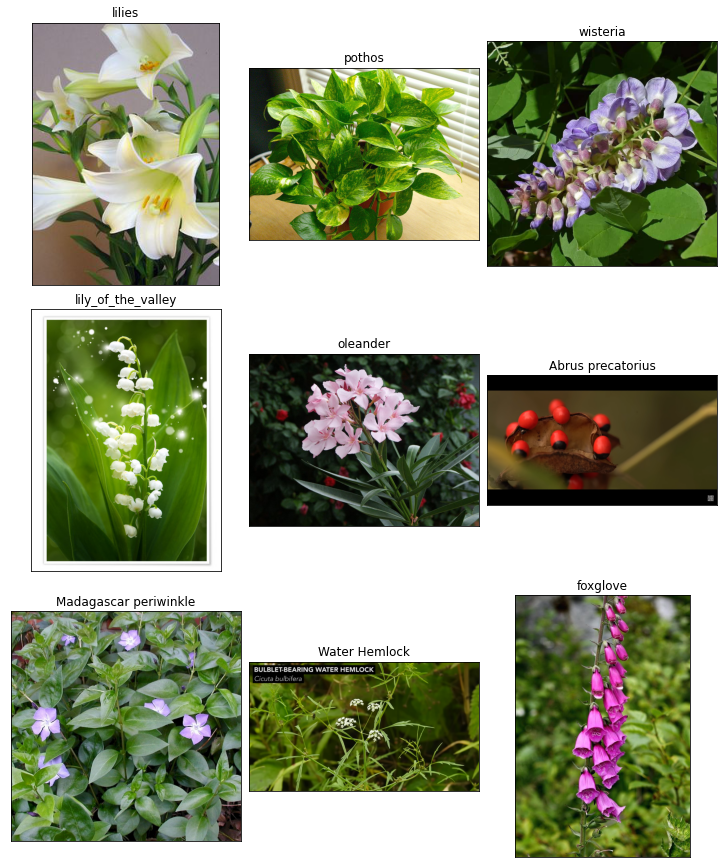

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [20]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 602 validated image filenames belonging to 12 classes.
Found 86 validated image filenames belonging to 12 classes.
Found 86 validated image filenames belonging to 12 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 34 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 4 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [32]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [33]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
19/19 [==============================] - 16s 719ms/step - loss: 1.7783 - accuracy: 0.4767 - val_loss: 0.7761 - val_accuracy: 0.8372
Epoch 2/50
19/19 [==============================] - 13s 719ms/step - loss: 0.5047 - accuracy: 0.8605 - val_loss: 0.3362 - val_accuracy: 0.9070
Epoch 3/50
19/19 [==============================] - 12s 639ms/step - loss: 0.2071 - accuracy: 0.9435 - val_loss: 0.3755 - val_accuracy: 0.8837
Epoch 4/50
19/19 [==============================] - 12s 618ms/step - loss: 0.1110 - accuracy: 0.9834 - val_loss: 0.2122 - val_accuracy: 0.9651
Epoch 5/50
19/19 [==============================] - 12s 623ms/step - loss: 0.0491 - accuracy: 0.9983 - val_loss: 0.2038 - val_accuracy: 0.9535
Epoch 6/50
19/19 [==============================] - 12s 632ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.2092 - val_accuracy: 0.9302
Epoch 7/50
19/19 [==============================] - 12s 647ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 0.9302

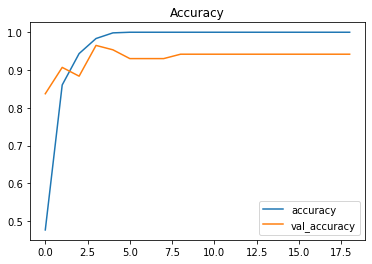

In [35]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()



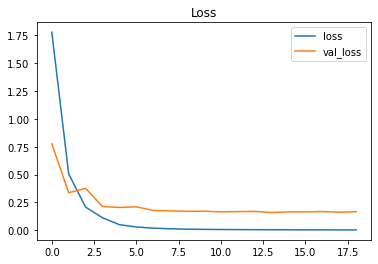

In [36]:

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [37]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

3/3 [==============================] - 3s 761ms/step


In [38]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 94.19%


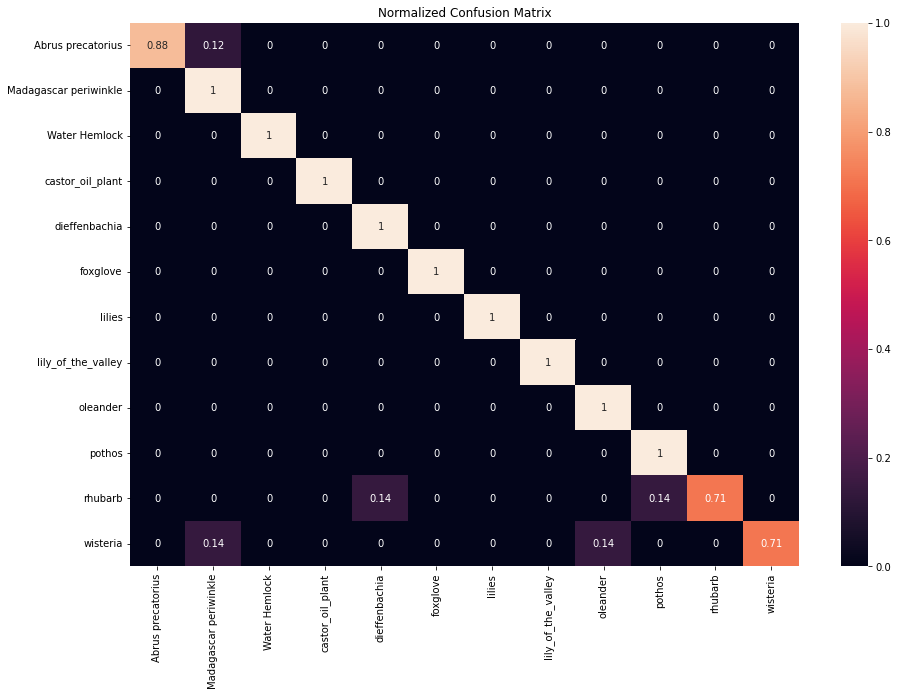

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

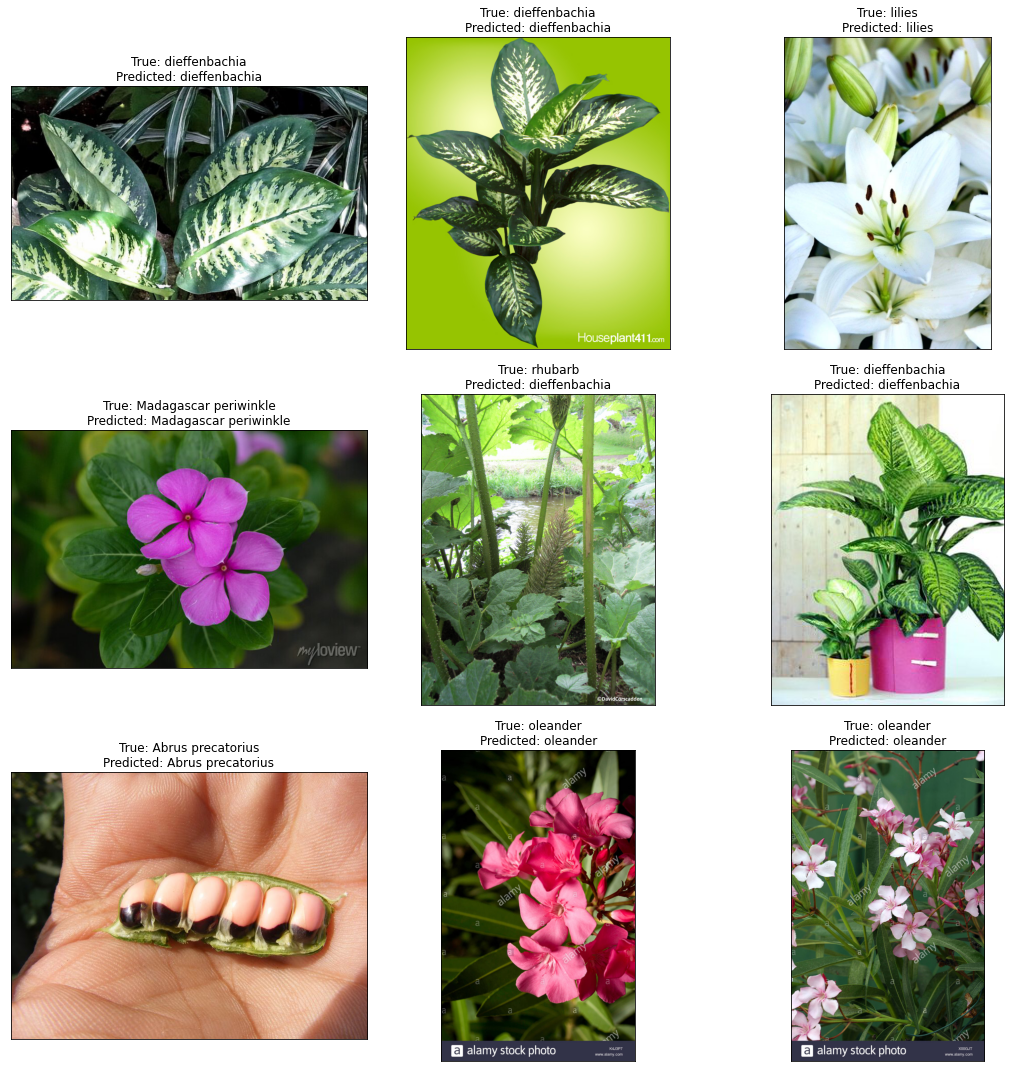

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [41]:
model.save('/content/model/12_16_22.h5')